# Sparsity Exploration Bayesian Optimization (SEBO) Ax API 

This tutorial introduces the Sparsity Exploration Bayesian Optimization (SEBO) method and demonstrates how to utilize it using the Ax API. SEBO is designed to enhance Bayesian Optimization (BO) by taking the interpretability and simplicity of configurations into consideration. In essence, SEBO incorporates sparsity, modeled as the $L_0$ norm, as an additional objective in BO. By employing multi-objective optimization techniques such as Expected Hyper-Volume Improvement, SEBO enables the joint optimization of objectives while simultaneously incorporating feature-level sparsity. This allows users to efficiently explore different trade-offs between objectives and sparsity.


For a more detailed understanding of the SEBO algorithm, please refer to the following publication:

[1] [S. Liu, Q. Feng, D. Eriksson, B. Letham and E. Bakshy. Sparse Bayesian Optimization. International Conference on Artificial Intelligence and Statistics, 2023.](https://proceedings.mlr.press/v206/liu23b/liu23b.pdf)

By following this tutorial, you will learn how to leverage the SEBO method through the Ax API, empowering you to effectively balance objectives and sparsity in your optimization tasks. Let's get started!

In [0]:
import os

from ax import Data, Experiment, ParameterType, RangeParameter, SearchSpace
from ax.modelbridge.registry import Models
from ax.runners.synthetic import SyntheticRunner

import warnings
warnings.filterwarnings('ignore')

In [3]:
SMOKE_TEST = os.environ.get("SMOKE_TEST")

In [4]:
import torch


torch.manual_seed(12345)  # To always get the same Sobol points
tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

# Problem Setup 

In this simple experiment we use the Branin function embedded in a 10-dimensional space. Additional resources:
- To set up a custom metric for your problem, refer to the dedicated section of the Developer API tutorial: https://ax.dev/tutorials/gpei_hartmann_developer.html#8.-Defining-custom-metrics.
- To avoid needing to setup up custom metrics by Ax Service API: https://ax.dev/tutorials/gpei_hartmann_service.html.

In [6]:
import math 
import numpy as np
from ax.core.objective import Objective
from ax.core.optimization_config import OptimizationConfig
from ax.metrics.noisy_function import NoisyFunctionMetric
from ax import Metric
from ax.utils.common.typeutils import checked_cast


aug_dim = 8 

search_space = SearchSpace(
    parameters=[
        RangeParameter(
            name=f"x{i}",
            parameter_type=ParameterType.FLOAT, 
            lower=0.0, upper=1.0
        )
        for i in range(aug_dim)
    ]
)

def branin_augment(x_vec, augment_dim):
    assert len(x_vec) == augment_dim
    x1, x2 = (
        15 * x_vec[0] - 5,
        15 * x_vec[1],
    )  # Only dimensions 0 and augment_dim-1 affect the value of the function
    t1 = x2 - 5.1 / (4 * math.pi**2) * x1**2 + 5 / math.pi * x1 - 6
    t2 = 10 * (1 - 1 / (8 * math.pi)) * np.cos(x1)
    return t1**2 + t2 + 10


class AugBraninMetric(NoisyFunctionMetric):
    def f(self, x: np.ndarray) -> float:
        return checked_cast(float, branin_augment(x_vec=x, augment_dim=aug_dim))

In [ ]:
# Create optimization goals 
optimization_config = OptimizationConfig(
    objective=Objective(
        metric=AugBraninMetric(
            name="objective",
            param_names=[f"x{i}" for i in range(aug_dim)],
            noise_sd=0.01,  # Set noise_sd=None if you want to learn the noise, otherwise it defaults to 1e-6
        ),
        minimize=True,
    )
)

# Experiment
experiment = Experiment(
    name="sebo_experiment",
    search_space=search_space,
    optimization_config=optimization_config,
    runner=SyntheticRunner(),
)

# target sparse point to regularize towards to. Here we set target sparse value being zero for all the parameters. 
target_point = torch.tensor([0 for _ in range(aug_dim)], **tkwargs)

# Benchmark 

In [7]:
import torch 
from ax.models.torch.botorch_modular.surrogate import Surrogate
from botorch.models import FixedNoiseGP, SaasFullyBayesianSingleTaskGP
from ax.fb.models.torch.botorch_modular.sebo import SEBOAcquisition
from botorch.acquisition.multi_objective import qNoisyExpectedHypervolumeImprovement

In [8]:
N_INIT = 10
BATCH_SIZE = 1

if SMOKE_TEST:
    N_BATCHES = 1
else:
    N_BATCHES = 40

print(f"Doing {N_INIT + N_BATCHES * BATCH_SIZE} evaluations")

Doing 50 evaluations


In [9]:
# Initial Sobol points
sobol = Models.SOBOL(search_space=experiment.search_space)
for _ in range(N_INIT):
    experiment.new_trial(sobol.gen(1)).run()

In [10]:
data = experiment.fetch_data()

for i in range(N_BATCHES):

    model = Models.BOTORCH_MODULAR(
        experiment=experiment, 
        data=data,
        surrogate=Surrogate(botorch_model_class=SaasFullyBayesianSingleTaskGP),  # can use SAASGP (i.e. SaasFullyBayesianSingleTaskGP) for high-dim cases
        search_space=experiment.search_space,
        botorch_acqf_class=qNoisyExpectedHypervolumeImprovement,
        acquisition_class=SEBOAcquisition,
        acquisition_options={
            "penalty": "L0_norm", # it can be L0_norm or L1_norm. 
            "target_point": target_point, 
            "sparsity_threshold": aug_dim,
        },
        torch_device=tkwargs['device'],
    )

    generator_run = model.gen(BATCH_SIZE)
    trial = experiment.new_batch_trial(generator_run=generator_run)
    trial.run()

    new_data = trial.fetch_data(metrics=list(experiment.metrics.values()))
    data = Data.from_multiple_data([data, new_data])
    print(f"Iteration: {i}, Best so far: {data.df['mean'].min():.3f}")

Iteration: 0, Best so far: 2.495


Iteration: 1, Best so far: 2.495


Iteration: 2, Best so far: 2.495


Iteration: 3, Best so far: 2.495


Iteration: 4, Best so far: 2.495


Iteration: 5, Best so far: 2.495


Iteration: 6, Best so far: 2.495


Iteration: 7, Best so far: 2.495


Iteration: 8, Best so far: 2.495


Iteration: 9, Best so far: 2.495


Iteration: 10, Best so far: 2.495


Iteration: 11, Best so far: 2.495


Iteration: 12, Best so far: 2.495


Iteration: 13, Best so far: 2.495


Iteration: 14, Best so far: 2.495


Iteration: 15, Best so far: 2.495


Iteration: 16, Best so far: 2.495


Iteration: 17, Best so far: 2.495


Iteration: 18, Best so far: 0.935


Iteration: 19, Best so far: 0.935


Iteration: 20, Best so far: 0.935


Iteration: 21, Best so far: 0.469


Iteration: 22, Best so far: 0.469


Iteration: 23, Best so far: 0.469


Iteration: 24, Best so far: 0.450


Iteration: 25, Best so far: 0.439


Iteration: 26, Best so far: 0.432


Iteration: 27, Best so far: 0.432


Iteration: 28, Best so far: 0.432


Iteration: 29, Best so far: 0.432


Iteration: 30, Best so far: 0.432


Iteration: 31, Best so far: 0.432


Iteration: 32, Best so far: 0.432


Iteration: 33, Best so far: 0.432


Iteration: 34, Best so far: 0.432


Iteration: 35, Best so far: 0.400


Iteration: 36, Best so far: 0.400


Iteration: 37, Best so far: 0.400


Iteration: 38, Best so far: 0.400


Iteration: 39, Best so far: 0.400


# Plot sparisty vs objective 

In [11]:
def nnz_exact(x, sparse_point):
    return len(x) - (np.array(x) == np.array(sparse_point)).sum()

    
df = data.df
df['L0_norm'] = df['arm_name'].apply(lambda d: nnz_exact(list(experiment.arms_by_name[d].parameters.values()), [0 for _ in range(aug_dim)]) )

In [12]:
result_by_sparsity = {l: df[df.L0_norm <= l]['mean'].min() for l in range(1, aug_dim+1)}
result_by_sparsity

{1: 5.50837634579411,
 2: 0.44683255375296044,
 3: 0.4321919928296593,
 4: 0.40015694600429746,
 5: 0.40015694600429746,
 6: 0.40015694600429746,
 7: 0.40015694600429746,
 8: 0.40015694600429746}

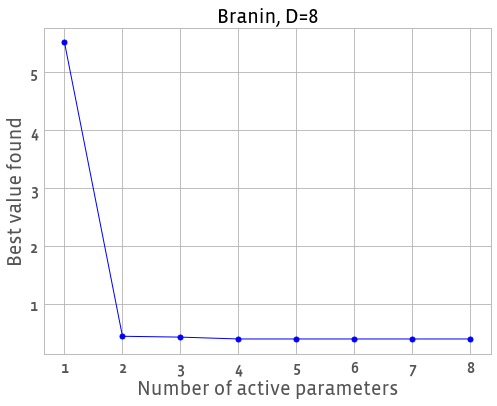

In [14]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
matplotlib.rcParams.update({"font.size": 16})

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(list(result_by_sparsity.keys()), list(result_by_sparsity.values()), '.b-', label="sebo", markersize=10)
ax.grid(True)
ax.set_title(f"Branin, D={aug_dim}", fontsize=20)
ax.set_xlabel("Number of active parameters", fontsize=20)
ax.set_ylabel("Best value found", fontsize=20)
# ax.legend(fontsize=18)
plt.show()